In [1]:
## Standard libraries
import os
import pandas as pd
from tabulate import tabulate

## Seeds
import random
import numpy as np

## PyTorch
import torch
import torch.utils.data as data

# Custom libraries
from networks.SimpleMLPs import MLPsumV2
from dataloader_pickles import DataloaderEvalV5
import utils
from pytorch_metric_learning import losses, distances
from tqdm import tqdm

## UMAP libraries
import matplotlib.pyplot as plt
import umap.plot
import matplotlib as mpl
import copy
import plotly.express as px

from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

NUM_WORKERS = 0
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Set random seed for reproducibility
manualSeed = 42
random.seed(manualSeed)
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)


In [2]:
#%%
# Load model
save_name_extension = 'general_ckpt_simpleMLP_V1'
model_name = save_name_extension
print('Loading:', model_name)

input_dim = 1324
kFilters = 1/2
latent_dim = 2048
output_dim = 2048
model = MLPsumV2(input_dim=input_dim, latent_dim=latent_dim, output_dim=output_dim,
                 k=kFilters, dropout=0, cell_layers=1,
                 proj_layers=2, reduction='sum')
if torch.cuda.is_available():
    model.cuda()

path = r'/Users/rdijk/PycharmProjects/featureAggregation/wandb/run-20220505_221947-1m1zas58/files'

models = os.listdir(path)
fullpath = os.path.join(path, model_name)
if 'ckpt' in model_name:
    model.load_state_dict(torch.load(fullpath)['model_state_dict'])
else:
    model.load_state_dict(torch.load(fullpath))
model.eval()

#%% Select specific plate and compound
plates = ['BR00112197binned_FS']

Loading: general_ckpt_simpleMLP_V1


In [3]:
#%%
# Load all data
rootDir = r'/Users/rdijk/PycharmProjects/featureAggregation/datasets/Stain2'
metadata = pd.read_csv('/Users/rdijk/Documents/Data/RawData/Stain2/JUMP-MOA_compound_platemap_with_metadata.csv', index_col=False)
plateDirs = [x[0] for x in os.walk(rootDir)][1:]

plateDirs = [x for x in plateDirs if any(substr in x for substr in plates)]

platestring = plateDirs[0].split('_')[-2]
print('Calculating results for: ' + platestring)
metadata = utils.addDataPathsToMetadata(rootDir, metadata, plateDirs)

# Filter the data and create numerical labels
df_prep = utils.filterData(metadata, '', encode='pert_iname')
# Add all data to one DF
Total, _ = utils.train_val_split(df_prep, 1.0, sort=False)
Total = Total.sort_values(by='Metadata_labels')

# Select only validation compounds
#valTotal = Total.sort_values(by='Metadata_labels').iloc[288:, :].reset_index(drop=True)

valset = DataloaderEvalV5(Total)
full_loader = data.DataLoader(valset, batch_size=1, shuffle=False, # 96
                         drop_last=False, pin_memory=False, num_workers=NUM_WORKERS)


Calculating results for: BR00112197binned


In [4]:
# Calculate profiles
MLP_profiles = pd.DataFrame()
with torch.no_grad():
    for idx, (points, labels) in enumerate(tqdm(full_loader)):
        feats, _ = model(points) 
        c1 = pd.concat([pd.DataFrame(feats), pd.Series(labels)], axis=1)
        MLP_profiles = pd.concat([MLP_profiles, c1])
MLP_profiles.columns = [f"f{x}" for x in range(MLP_profiles.shape[1] - 1)] + ['Metadata_labels']
MLP_profiles = MLP_profiles.reset_index(drop=True)

100%|█████████████████████████████████████████| 384/384 [00:27<00:00, 13.85it/s]


In [5]:
metadata.sort_values(by='Metadata_labels').reset_index(drop=True).iloc[384-48:].reset_index(drop=True)

,well_position,broad_sample,solvent,InChIKey,pert_iname,pubchem_cid,moa,smiles,pert_type,control_type,plate1,Metadata_labels
0,H22,BRD-A12994259-001-02-1,DMSO,UVSMNLNDYGZFPF-UHFFFAOYSA-N,pomalidomide,134780.0,tumor necrosis factor production inhibitor,Nc1cccc2C(=O)N(C3CCC(=O)NC3=O)C(=O)c12,trt,NaN,/Users/rdijk/PycharmProjects/featureAggregatio...,79
1,N17,BRD-A12994259-001-02-1,DMSO,UVSMNLNDYGZFPF-UHFFFAOYSA-N,pomalidomide,134780.0,tumor necrosis factor production inhibitor,Nc1cccc2C(=O)N(C3CCC(=O)NC3=O)C(=O)c12,trt,NaN,/Users/rdijk/PycharmProjects/featureAggregatio...,79
2,O03,BRD-A12994259-001-02-1,DMSO,UVSMNLNDYGZFPF-UHFFFAOYSA-N,pomalidomide,134780.0,tumor necrosis factor production inhibitor,Nc1cccc2C(=O)N(C3CCC(=O)NC3=O)C(=O)c12,trt,NaN,/Users/rdijk/PycharmProjects/featureAggregatio...,79
3,K04,BRD-A12994259-001-02-1,DMSO,UVSMNLNDYGZFPF-UHFFFAOYSA-N,pomalidomide,134780.0,tumor necrosis factor production inhibitor,Nc1cccc2C(=O)N(C3CCC(=O)NC3=O)C(=O)c12,trt,NaN,/Users/rdijk/PycharmProjects/featureAggregatio...,79
4,D11,BRD-K44227013-001-08-0,DMSO,PHXJVRSECIGDHY-UHFFFAOYSA-N,ponatinib,24826799.0,Bcr-Abl kinase inhibitor,CN1CCN(Cc2ccc(NC(=O)c3ccc(C)c(c3)C#Cc3cnc4cccn...,trt,NaN,/Users/rdijk/PycharmProjects/featureAggregatio...,80
5,K23,BRD-K44227013-001-08-0,DMSO,PHXJVRSECIGDHY-UHFFFAOYSA-N,ponatinib,24826799.0,Bcr-Abl kinase inhibitor,CN1CCN(Cc2ccc(NC(=O)c3ccc(C)c(c3)C#Cc3cnc4cccn...,trt,NaN,/Users/rdijk/PycharmProjects/featureAggregatio...,80
6,H04,BRD-K44227013-001-08-0,DMSO,PHXJVRSECIGDHY-UHFFFAOYSA-N,ponatinib,24826799.0,Bcr-Abl kinase inhibitor,CN1CCN(Cc2ccc(NC(=O)c3ccc(C)c(c3)C#Cc3cnc4cccn...,trt,NaN,/Users/rdijk/PycharmProjects/featureAggregatio...,80
7,A24,BRD-K44227013-001-08-0,DMSO,PHXJVRSECIGDHY-UHFFFAOYSA-N,ponatinib,24826799.0,Bcr-Abl kinase inhibitor,CN1CCN(Cc2ccc(NC(=O)c3ccc(C)c(c3)C#Cc3cnc4cccn...,trt,NaN,/Users/rdijk/PycharmProjects/featureAggregatio...,80
8,M07,BRD-K73397362-001-06-6,DMSO,FYBHCRQFSFYWPY-UHFFFAOYSA-N,purmorphamine,5284329.0,smoothened receptor agonist,C1CCC(CC1)n1cnc2c(Nc3ccc(cc3)N3CCOCC3)nc(Oc3cc...,trt,NaN,/Users/rdijk/PycharmProjects/featureAggregatio...,81
9,M08,BRD-K73397362-001-06-6,DMSO,FYBHCRQFSFYWPY-UHFFFAOYSA-N,purmorphamine,5284329.0,smoothened receptor agonist,C1CCC(CC1)n1cnc2c(Nc3ccc(cc3)N3CCOCC3)nc(Oc3cc...,trt,NaN,/Users/rdijk/PycharmProjects/featureAggregatio...,81


In [6]:
#%% Choose which wells to calculate saliencies for

point_list = [8, 9, 10, 11]

WELLS = list(metadata.sort_values(by='Metadata_labels').reset_index(drop=True).iloc[384-48:].reset_index(drop=True).loc[point_list, 'well_position'])
PERTURBATIONS = list(metadata.sort_values(by='Metadata_labels').reset_index(drop=True).iloc[384-48:].reset_index(drop=True).loc[point_list, 'pert_iname'])
print(WELLS, PERTURBATIONS)

['M07', 'M08', 'N24', 'B17'] ['purmorphamine', 'purmorphamine', 'purmorphamine', 'purmorphamine']


In [7]:
metadata_indices_used = []
for i in range(len(WELLS)):
    a = metadata.sort_values(by='Metadata_labels').reset_index(drop=True)[metadata['well_position'] == WELLS[i]].index
    metadata_indices_used.append(a)

In [8]:
mask_list = []
dataloader_list = []
for well in WELLS:
    # Load single well data
    mask = df_prep.well_position == well
    df_prep_masked = df_prep.loc[mask]
    # Add all data to one DF
    singleWell, _ = utils.train_val_split(df_prep_masked, 1.0, sort=False)

    smallset = DataloaderEvalV5(singleWell)
    dataloader = data.DataLoader(smallset, batch_size=1, shuffle=False,
                             drop_last=False, pin_memory=False, num_workers=NUM_WORKERS)
    
    mask_list.append(mask)
    dataloader_list.append(dataloader)

In [9]:
df_prep_masked.head() # Show last one in for loop

,well_position,broad_sample,solvent,InChIKey,pert_iname,pubchem_cid,moa,smiles,pert_type,control_type,plate1,Metadata_labels
40,B17,BRD-K73397362-001-06-6,DMSO,FYBHCRQFSFYWPY-UHFFFAOYSA-N,purmorphamine,5284329.0,smoothened receptor agonist,C1CCC(CC1)n1cnc2c(Nc3ccc(cc3)N3CCOCC3)nc(Oc3cc...,trt,NaN,/Users/rdijk/PycharmProjects/featureAggregatio...,81


In [10]:
def SNR(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

In [11]:
def N(a):
    a = np.asanyarray(a)
    m = a[0, :].mean()
    N = np.sqrt(np.mean((m - a)**2, 1))
    return N

## Saliency V0 - Activation layer based slaliency (L1 norm per cell)

torch.Size([604, 1324])


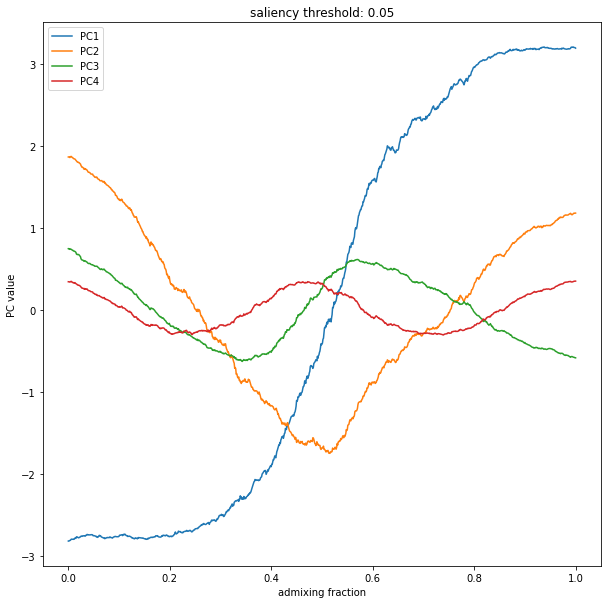

torch.Size([1210, 1324])


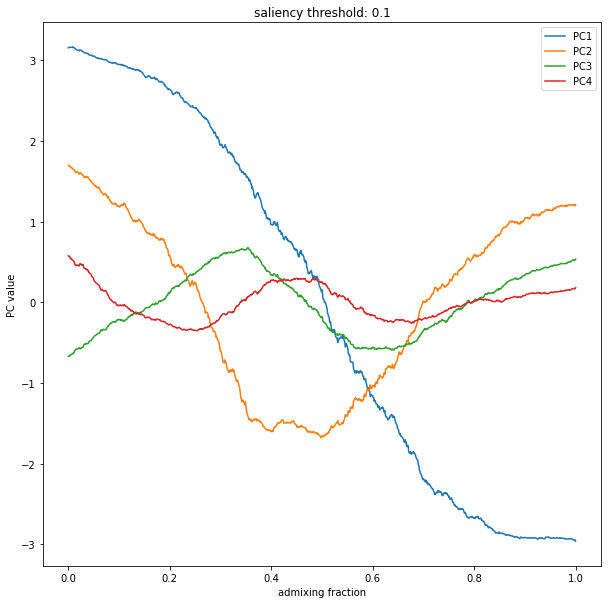

torch.Size([2422, 1324])


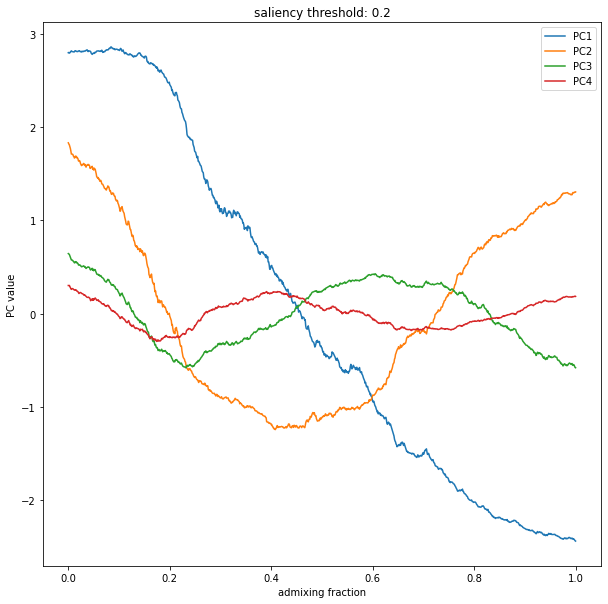

torch.Size([4846, 1324])


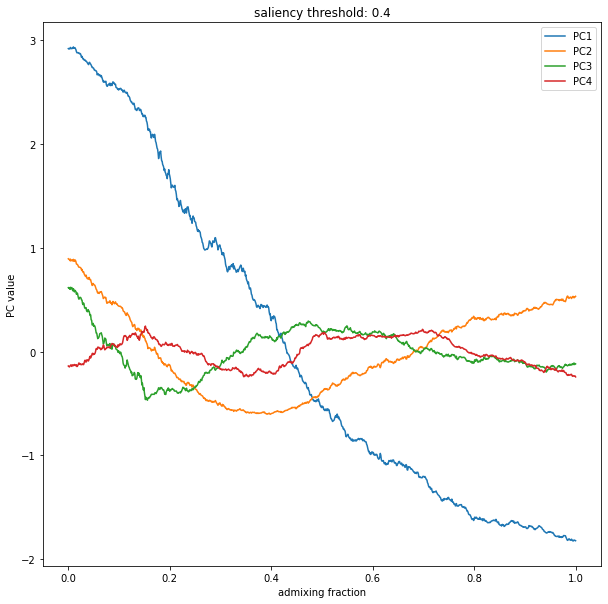

torch.Size([12120, 1324])


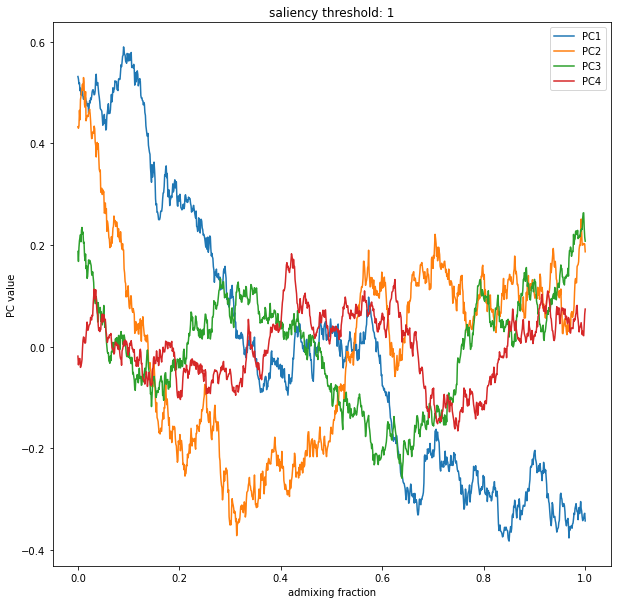

In [12]:
admixing_fractions = [0.05, 0.1, 0.2, 0.4, 1]
for frac in admixing_fractions:

    highpoints = []
    lowpoints = []

    for loader, mask in zip(dataloader_list, mask_list):
        points, clabel = next(iter(loader))

        _, profile = model(points)

        saliency_V0 = torch.sum(abs(profile), dim=2)

        saliency_V0 = np.squeeze(np.array(saliency_V0.detach()))

        cutoff = int(points.shape[1]*frac)
        topidx = sorted(range(len(saliency_V0)), key=lambda i: saliency_V0[i])[-cutoff:]
        botidx = sorted(range(len(saliency_V0)), key=lambda i: saliency_V0[i])[:cutoff]
        highpoints.append(points[0,topidx,:])
        lowpoints.append(points[0,botidx,:])
    
    highpoints = torch.cat(highpoints)
    lowpoints = torch.cat(lowpoints)
    print(highpoints.shape)
    
    ## PERMUTATION TEST
    NPERM = 1000
    npcas = 4
    ncells = highpoints.shape[0]

    noutputs = []
    
    ridxh = np.random.choice(ncells, NPERM)
    highcells_pool = highpoints[ridxh, :].detach()
    ridxl = np.random.choice(ncells, NPERM+1)
    lowcells = lowpoints[ridxl, :].detach()
    for x in range(NPERM+1):
        lowcells = np.delete(lowcells, 0, 0)
        highcells = highcells_pool[:x, :]

        fusedcells = torch.unsqueeze(torch.cat([highcells, lowcells]), 0)

        profile, _ = model(fusedcells)
        profile = profile.detach().numpy()[0,...]
        # Normalize profiles (per row)
        profile = (profile - np.min(profile)) / (np.max(profile) - np.min(profile))
        noutputs.append(profile)

    # Calculate PCAs
    pca = PCA(n_components=npcas, random_state=42)
    pcs = pca.fit_transform(np.stack(noutputs))
    

    fig, ax = plt.subplots(1,1, figsize = (10,10))
    for i in range(npcas):
        ax.plot(np.array(range(NPERM+1))/NPERM, pcs[:,i], label=f'PC{i+1}')
    ax.legend()

    ax.set_xlabel('admixing fraction')
    ax.set_ylabel('PC value')
    ax.set_title(f'saliency threshold: {frac}')
    plt.show()

#     fig, ax = plt.subplots(1,2, figsize = (15,10))
#     for i in range(npcas):
#         ax[0].plot(np.array(range(NPERM+1))/NPERM, pcs[:,i], label=f'PC{i+1}')
#     ax[0].legend()

#     ax[0].set_xlabel('admixing fraction')
#     ax[0].set_ylabel('PC value')
#     ax[0].set_title(f'saliency threshold: {frac}')
    
#     # Calculate signal to noise ratios 
#     snrs = SNR(np.stack(noutputs), 1)
#     ax[1].plot(np.array(range(NPERM+1))/NPERM, snrs)

#     ax[1].set_xlabel('admixing fraction')
#     ax[1].set_ylabel('SNR (-)')
#     ax[1].set_title(f'SNR with saliency threshold: {frac}')
#     plt.show()


## Saliency V1 - Gradient based saliency (L1 norm per cell)

torch.Size([604, 1324])


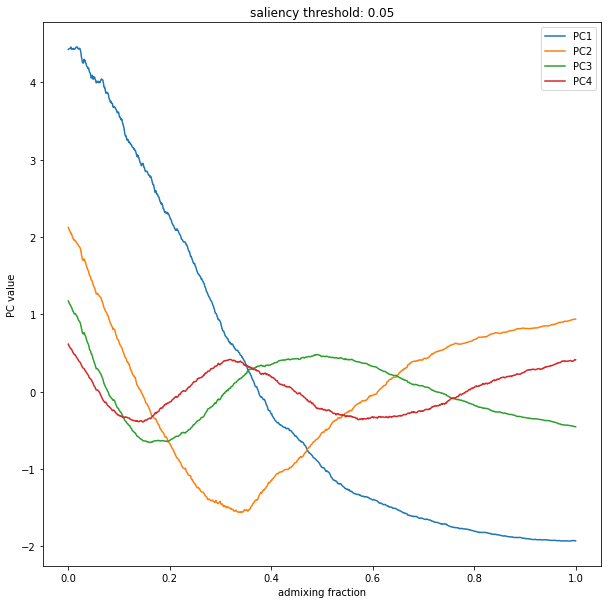

torch.Size([1210, 1324])


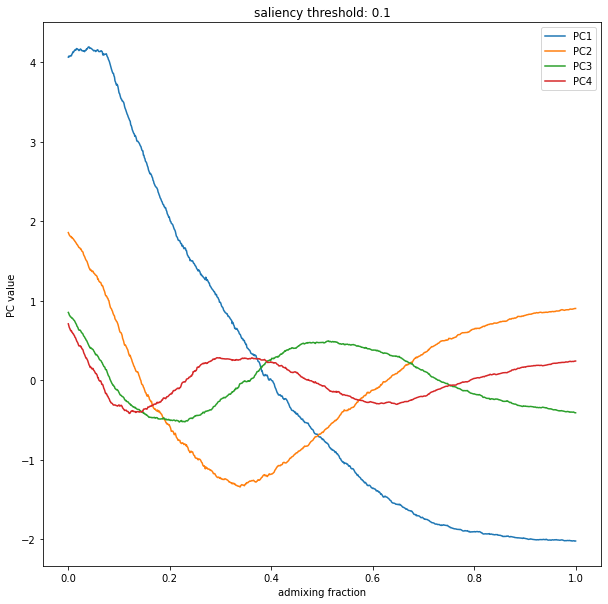

torch.Size([2422, 1324])


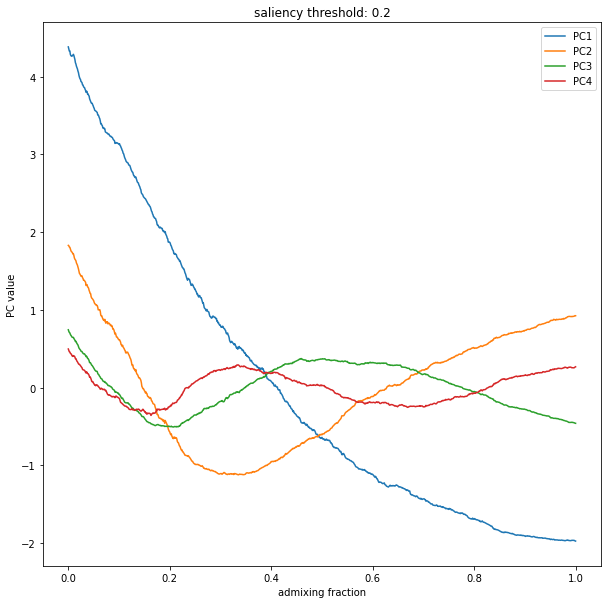

torch.Size([4846, 1324])


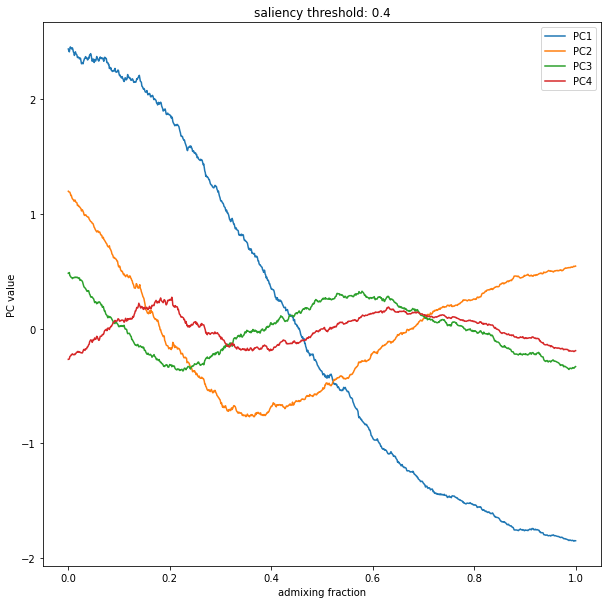

torch.Size([12120, 1324])


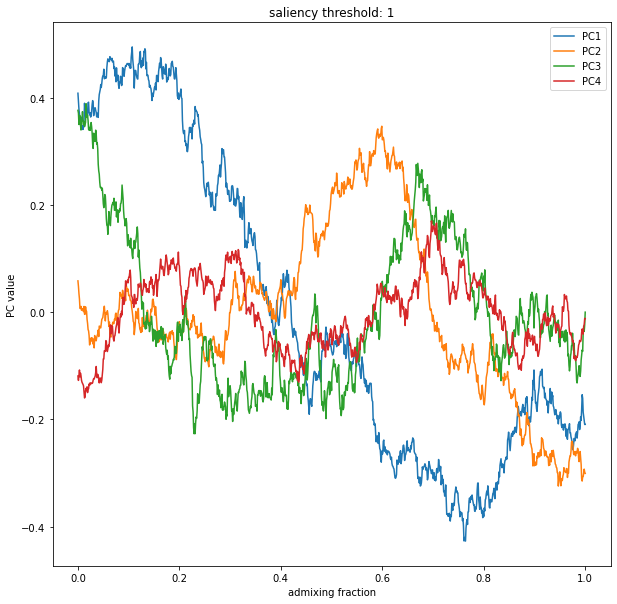

In [13]:
#%% Saliency_V1 Calculate gradient based saliencies - L1 norm of gradients per cell 
loss_func = losses.SupConLoss(distance=distances.CosineSimilarity())

admixing_fractions = [0.05, 0.1, 0.2, 0.4, 1]
for frac in admixing_fractions:

    highpoints = []
    lowpoints = []

    for loader, mask in zip(dataloader_list, mask_list):
        points, clabel = next(iter(loader))

        MLP_profiles_masked = MLP_profiles[~mask] # remove well profile that we are analysing
        points.requires_grad_()
        profile, _ = model(points)

        L = loss_func(torch.cat([torch.tensor(MLP_profiles_masked.iloc[:, :-1].values), profile]), 
                      torch.cat([torch.tensor(MLP_profiles_masked.iloc[:, -1].values), clabel]))

        features_loss = L.backward()
        saliency_V1 = torch.sum(points.grad.data.abs(), dim=2)
        saliency_V1 = np.squeeze(np.array(saliency_V1))

        cutoff = int(points.shape[1]*frac)
        topidx = sorted(range(len(saliency_V1)), key=lambda i: saliency_V1[i])[-cutoff:]
        botidx = sorted(range(len(saliency_V1)), key=lambda i: saliency_V1[i])[:cutoff]
        highpoints.append(points[0,topidx,:])
        lowpoints.append(points[0,botidx,:])
    
    highpoints = torch.cat(highpoints)
    lowpoints = torch.cat(lowpoints)
    print(highpoints.shape)
    
    ## PERMUTATION TEST
    NPERM = 1000
    npcas = 4
    ncells = highpoints.shape[0]

    noutputs = []
    
    ridxh = np.random.choice(ncells, NPERM)
    highcells_pool = highpoints[ridxh, :].detach()
    ridxl = np.random.choice(ncells, NPERM+1)
    lowcells = lowpoints[ridxl, :].detach()
    for x in range(NPERM+1):
        lowcells = np.delete(lowcells, 0, 0)
        highcells = highcells_pool[:x, :]

        fusedcells = torch.unsqueeze(torch.cat([highcells, lowcells]), 0)

        profile, _ = model(fusedcells)
        profile = profile.detach().numpy()[0,...]
        # Normalize profiles (per row)
        profile = (profile - np.min(profile)) / (np.max(profile) - np.min(profile))
        noutputs.append(profile)

    # Calculate PCAs
    pca = PCA(n_components=npcas, random_state=42)
    pcs = pca.fit_transform(np.stack(noutputs))
    

    fig, ax = plt.subplots(1,1, figsize = (10,10))
    for i in range(npcas):
        ax.plot(np.array(range(NPERM+1))/NPERM, pcs[:,i], label=f'PC{i+1}')
    ax.legend()

    ax.set_xlabel('admixing fraction')
    ax.set_ylabel('PC value')
    ax.set_title(f'saliency threshold: {frac}')
    plt.show()

#     fig, ax = plt.subplots(1,2, figsize = (15,10))
#     for i in range(npcas):
#         ax[0].plot(np.array(range(NPERM+1))/NPERM, pcs[:,i], label=f'PC{i+1}')
#     ax[0].legend()

#     ax[0].set_xlabel('admixing fraction')
#     ax[0].set_ylabel('PC value')
#     ax[0].set_title(f'saliency threshold: {frac}')
    
#     # Calculate signal to noise ratios 
#     snrs = SNR(np.stack(noutputs), 1)
#     ax[1].plot(np.array(range(NPERM+1))/NPERM, snrs)

#     ax[1].set_xlabel('admixing fraction')
#     ax[1].set_ylabel('SNR (-)')
#     ax[1].set_title(f'SNR with saliency threshold: {frac}')
#     plt.show()

## Saliency V0 + Saliency V1

torch.Size([604, 1324])


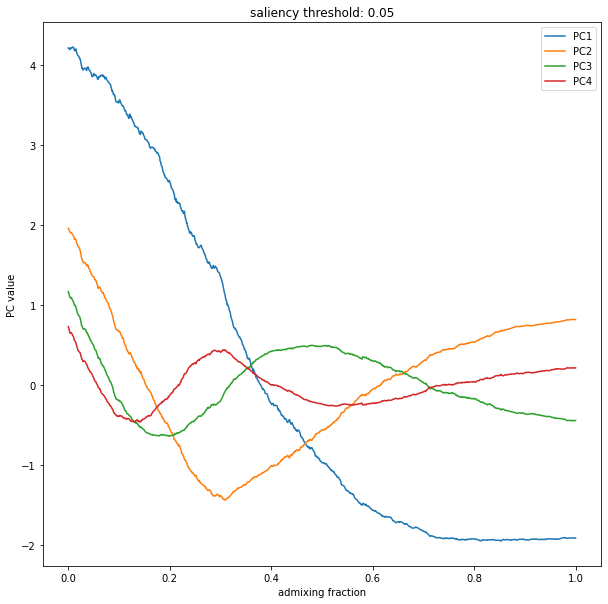

torch.Size([1210, 1324])


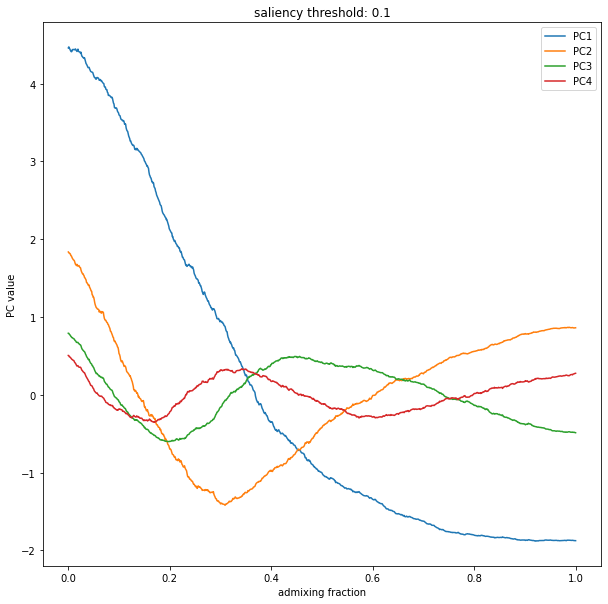

torch.Size([2422, 1324])


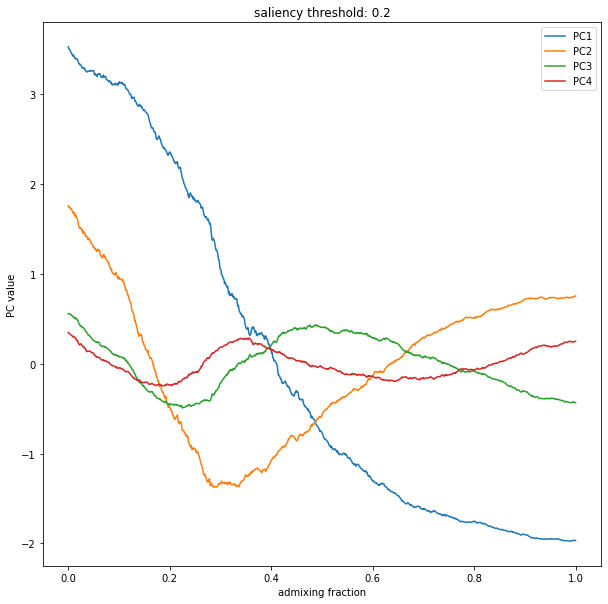

torch.Size([4846, 1324])


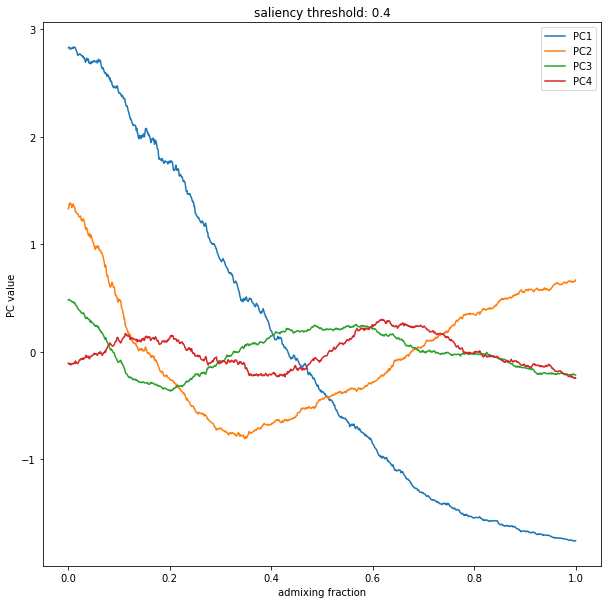

torch.Size([12120, 1324])


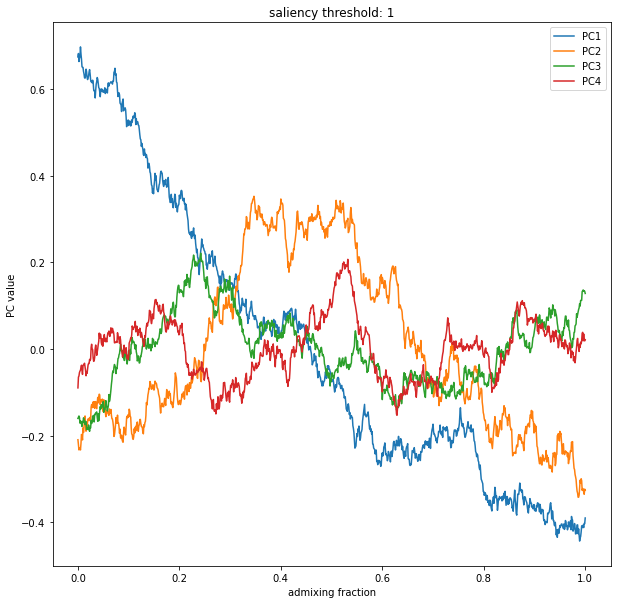

In [14]:
#%% Saliency_V1 Calculate gradient based saliencies - L1 norm of gradients per cell 
loss_func = losses.SupConLoss(distance=distances.CosineSimilarity())

admixing_fractions = [0.05, 0.1, 0.2, 0.4, 1]
for frac in admixing_fractions:

    highpoints = []
    lowpoints = []

    for loader, mask in zip(dataloader_list, mask_list):
        points, clabel = next(iter(loader))

        MLP_profiles_masked = MLP_profiles[~mask] # remove well profile that we are analysing
        points.requires_grad_()
        profile, features = model(points)
        
        saliency_V0 = torch.sum(abs(features), dim=2)
        saliency_V0 = np.squeeze(np.array(saliency_V0.detach()))
        
        L = loss_func(torch.cat([torch.tensor(MLP_profiles_masked.iloc[:, :-1].values), profile]), 
                      torch.cat([torch.tensor(MLP_profiles_masked.iloc[:, -1].values), clabel]))

        features_loss = L.backward()
        saliency_V1 = torch.sum(points.grad.data.abs(), dim=2)
        saliency_V1 = np.squeeze(np.array(saliency_V1))
        
        saliency_V0 = ( saliency_V0 - np.min(saliency_V0) ) / (np.max(saliency_V0) - np.min(saliency_V0))
        saliency_V1 = ( saliency_V1 - np.min(saliency_V1) ) / (np.max(saliency_V1) - np.min(saliency_V1))
        
        saliency_V0_V1 = saliency_V0 + saliency_V1
        
        cutoff = int(points.shape[1]*frac)
        topidx = sorted(range(len(saliency_V0_V1)), key=lambda i: saliency_V0_V1[i])[-cutoff:]
        botidx = sorted(range(len(saliency_V0_V1)), key=lambda i: saliency_V0_V1[i])[:cutoff]
        highpoints.append(points[0,topidx,:])
        lowpoints.append(points[0,botidx,:])
    
    highpoints = torch.cat(highpoints)
    lowpoints = torch.cat(lowpoints)
    print(highpoints.shape)
    
    ## PERMUTATION TEST
    NPERM = 1000
    npcas = 4
    ncells = highpoints.shape[0]

    noutputs = []
    
    ridxh = np.random.choice(ncells, NPERM)
    highcells_pool = highpoints[ridxh, :].detach()
    ridxl = np.random.choice(ncells, NPERM+1)
    lowcells = lowpoints[ridxl, :].detach()
    for x in range(NPERM+1):
        lowcells = np.delete(lowcells, 0, 0)
        highcells = highcells_pool[:x, :]

        fusedcells = torch.unsqueeze(torch.cat([highcells, lowcells]), 0)

        profile, _ = model(fusedcells)
        profile = profile.detach().numpy()[0,...]
        # Normalize profiles (per row)
        profile = (profile - np.min(profile)) / (np.max(profile) - np.min(profile))
        noutputs.append(profile)

    # Calculate PCAs
    pca = PCA(n_components=npcas, random_state=42)
    pcs = pca.fit_transform(np.stack(noutputs))
    

    fig, ax = plt.subplots(1,1, figsize = (10,10))
    for i in range(npcas):
        ax.plot(np.array(range(NPERM+1))/NPERM, pcs[:,i], label=f'PC{i+1}')
    ax.legend()

    ax.set_xlabel('admixing fraction')
    ax.set_ylabel('PC value')
    ax.set_title(f'saliency threshold: {frac}')
    plt.show()


## Saliency V2

100%|██████████████████████████████████████| 2924/2924 [00:09<00:00, 300.01it/s]


torch.Size([604, 1324])


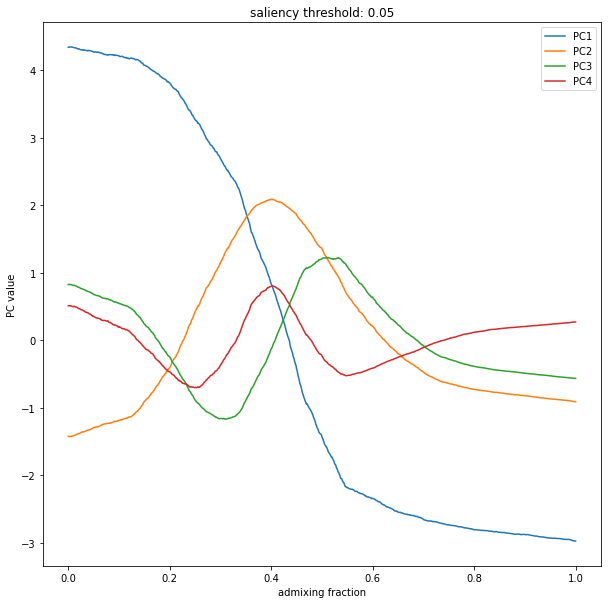

100%|██████████████████████████████████████| 2924/2924 [00:10<00:00, 289.77it/s]


torch.Size([1210, 1324])


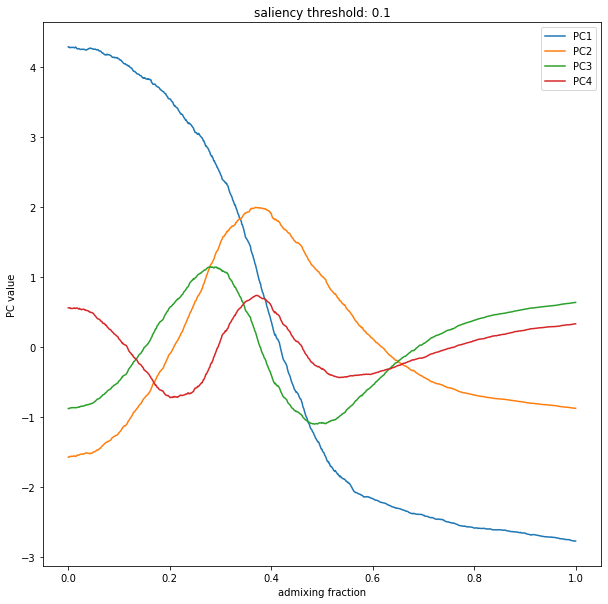

100%|██████████████████████████████████████| 2924/2924 [00:09<00:00, 298.25it/s]


torch.Size([2422, 1324])


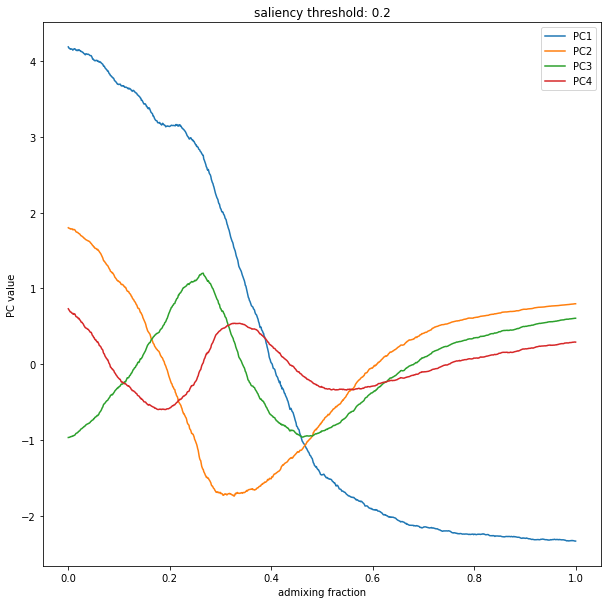

100%|██████████████████████████████████████| 2924/2924 [00:09<00:00, 309.63it/s]


torch.Size([4846, 1324])


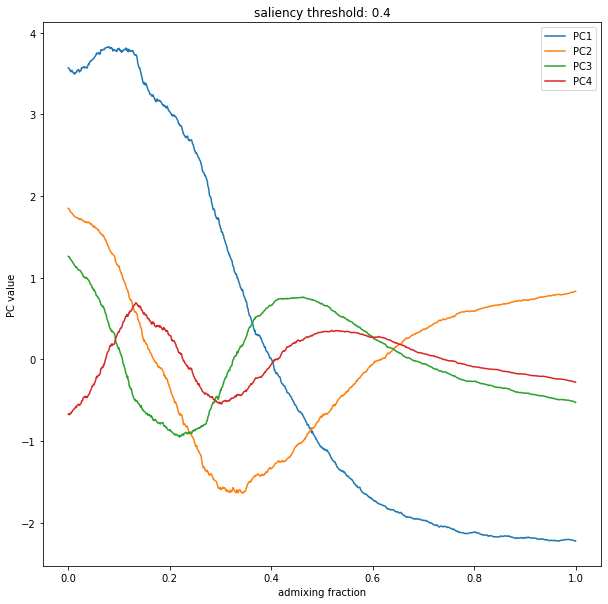

100%|██████████████████████████████████████| 2924/2924 [00:09<00:00, 293.28it/s]


torch.Size([12120, 1324])


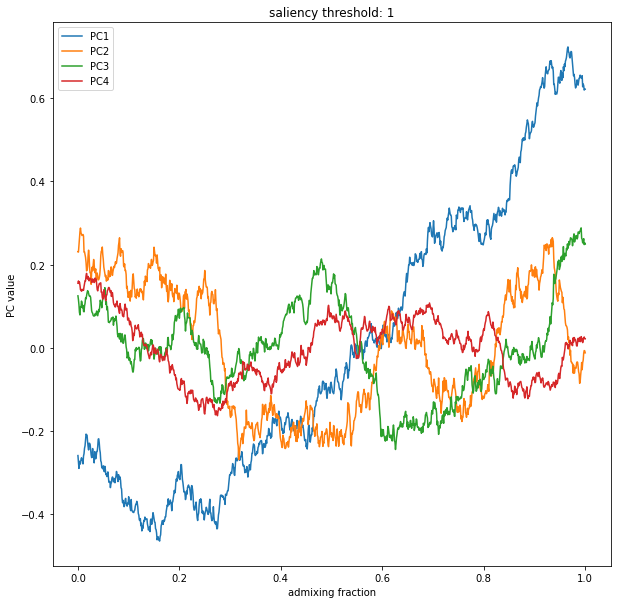

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Calculate distance based saliencies - distance of single cell representations to aggregated representation
admixing_fractions = [0.05, 0.1, 0.2, 0.4, 1]
for frac in admixing_fractions:

    highpoints = []
    lowpoints = []

    for loader in dataloader_list:
        points, clabel = next(iter(loader))

        single_cell_profiles = torch.tensor([])
        final_profile, _ = model(points)

        for idx in tqdm(range(points.shape[1])):
            single_cell = points[:, [idx], :]
            sc_profile, _ = model(single_cell)
            single_cell_profiles = torch.cat([single_cell_profiles, sc_profile])
        single_cell_profiles = single_cell_profiles.detach().numpy()
        final_profile = final_profile.detach().numpy()
        cos = cosine_similarity(single_cell_profiles, final_profile)[:, 0]

        cutoff = int(points.shape[1]*frac)
        topidx = sorted(range(len(cos)), key=lambda i: cos[i])[-cutoff:]
        botidx = sorted(range(len(cos)), key=lambda i: cos[i])[:cutoff]
        highpoints.append(points[0,topidx,:])
        lowpoints.append(points[0,botidx,:])
    
    highpoints = torch.cat(highpoints)
    lowpoints = torch.cat(lowpoints)
    print(highpoints.shape)
    
    ## PERMUTATION TEST
    NPERM = 1000
    npcas = 4
    ncells = highpoints.shape[0]

    noutputs = []
    
    ridxh = np.random.choice(ncells, NPERM)
    highcells_pool = highpoints[ridxh, :].detach()
    ridxl = np.random.choice(ncells, NPERM+1)
    lowcells = lowpoints[ridxl, :].detach()
    for x in range(NPERM+1):
        lowcells = np.delete(lowcells, 0, 0)
        highcells = highcells_pool[:x, :]

        fusedcells = torch.unsqueeze(torch.cat([highcells, lowcells]), 0)

        profile, _ = model(fusedcells)
        profile = profile.detach().numpy()[0,...]
        # Normalize profiles (per row)
        profile = (profile - np.min(profile)) / (np.max(profile) - np.min(profile))
        noutputs.append(profile)
    
    # Calculate PCAs
    pca = PCA(n_components=npcas, random_state=42)
    pcs = pca.fit_transform(np.stack(noutputs))
    

    fig, ax = plt.subplots(1,1, figsize = (10,10))
    for i in range(npcas):
        ax.plot(np.array(range(NPERM+1))/NPERM, pcs[:,i], label=f'PC{i+1}')
    ax.legend()

    ax.set_xlabel('admixing fraction')
    ax.set_ylabel('PC value')
    ax.set_title(f'saliency threshold: {frac}')
    plt.show()

#     fig, ax = plt.subplots(1,2, figsize = (15,10))
#     for i in range(npcas):
#         ax[0].plot(np.array(range(NPERM+1))/NPERM, pcs[:,i], label=f'PC{i+1}')
#     ax[0].legend()

#     ax[0].set_xlabel('admixing fraction')
#     ax[0].set_ylabel('PC value')
#     ax[0].set_title(f'saliency threshold: {frac}')
    
#     # Calculate signal to noise ratios 
# #     snrs = SNR(np.stack(noutputs), 1)
# #     snrs = N(np.stack(noutputs))
# #     ax[1].plot(np.array(range(NPERM+1))/NPERM, snrs)

#     x = np.array(range(NPERM+1))/NPERM
#     params = np.polyfit(x, pcs, 3)
#     fittedPCs = [P[0]*x**3 + P[1]*x**2 + P[2]*x**1 + P[3] for P in params]
#     for i in range(fittedPCs):
#         ax[1].plot(x, fittedPCs[:,i], label=f'PC{i+1}')

#     ax[1].set_xlabel('admixing fraction')
#     ax[1].set_ylabel('SNR (-)')
#     ax[1].set_title(f'SNR with saliency threshold: {frac}')
#     plt.show()

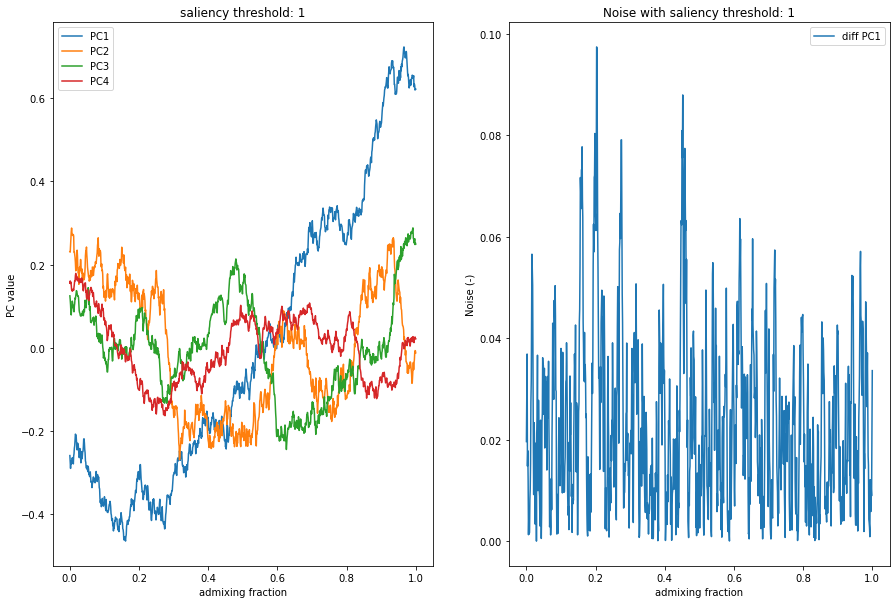

In [16]:
    fig, ax = plt.subplots(1,2, figsize = (15,10))
    for i in range(npcas):
        ax[0].plot(np.array(range(NPERM+1))/NPERM, pcs[:,i], label=f'PC{i+1}')
    ax[0].legend()

    ax[0].set_xlabel('admixing fraction')
    ax[0].set_ylabel('PC value')
    ax[0].set_title(f'saliency threshold: {frac}')
    
    # Calculate signal to noise ratios 
#     snrs = SNR(np.stack(noutputs), 1)
#     snrs = N(np.stack(noutputs))
#     ax[1].plot(np.array(range(NPERM+1))/NPERM, snrs)

    x = np.array(range(NPERM+1))/NPERM
    power = 15
    params = np.polyfit(x, pcs[:, 0], power)
    fittedPC1 = 0
    for P in range(len(params)):
        fittedPC1 += params[P]*x**(power-P)
    diffFit = abs(fittedPC1 - pcs[:, 0])
#    ax[1].plot(x, fittedPC1, label=f'fit PC1')
    ax[1].plot(x, diffFit, label=f'diff PC1')
    ax[1].legend()

    ax[1].set_xlabel('admixing fraction')
    ax[1].set_ylabel('Noise (-)')
    ax[1].set_title(f'Noise with saliency threshold: {frac}')
    plt.show()

## Saliency V3

100%|███████████████████████████████████████| 2924/2924 [03:26<00:00, 14.17it/s]


torch.Size([604, 1324])


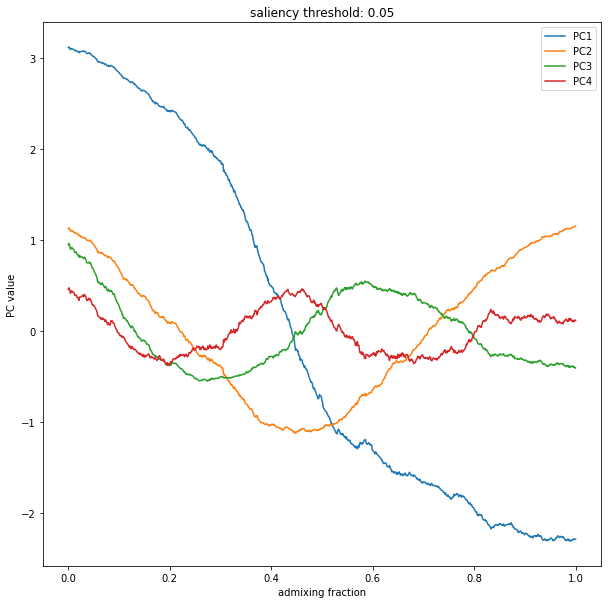

100%|███████████████████████████████████████| 2924/2924 [03:26<00:00, 14.17it/s]


torch.Size([1210, 1324])


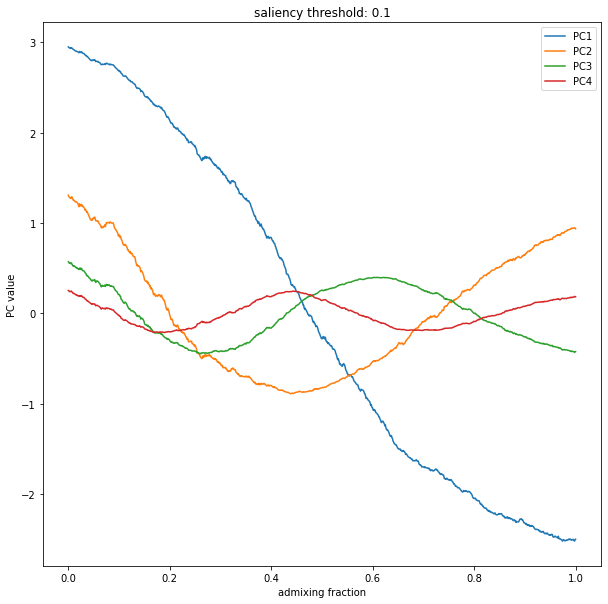

100%|███████████████████████████████████████| 2924/2924 [02:53<00:00, 16.88it/s]


torch.Size([2422, 1324])


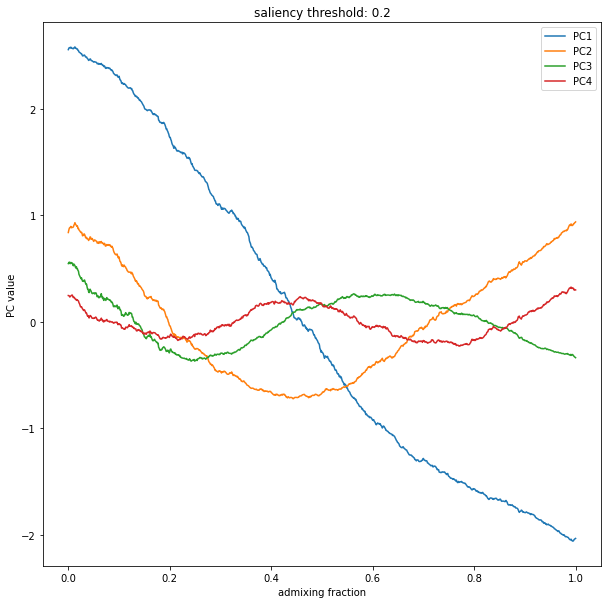

100%|███████████████████████████████████████| 2924/2924 [02:46<00:00, 17.53it/s]


torch.Size([4846, 1324])


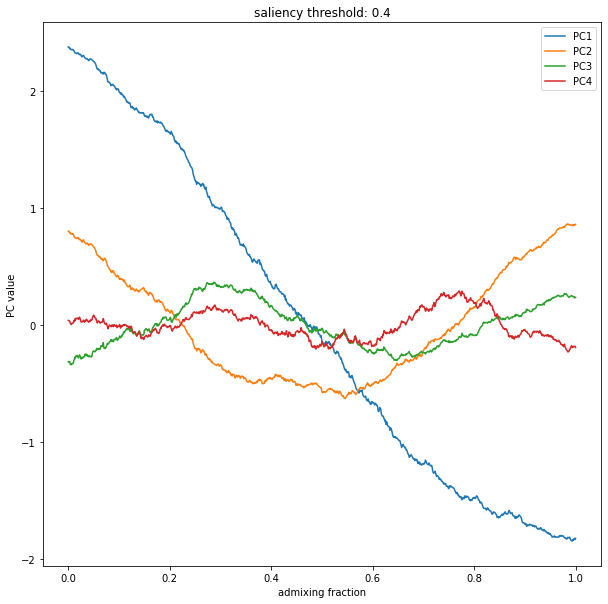

100%|███████████████████████████████████████| 2924/2924 [02:49<00:00, 17.25it/s]


torch.Size([12120, 1324])


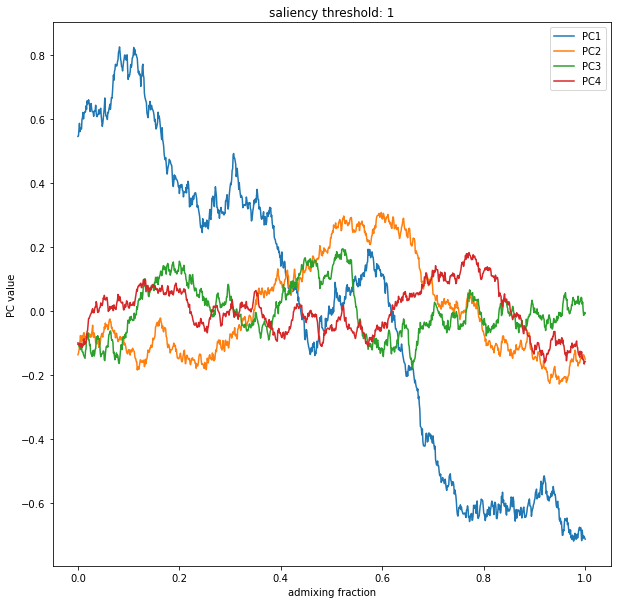

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Calculate distance based saliencies - distance of single cell representations to aggregated representation
admixing_fractions = [0.05, 0.1, 0.2, 0.4, 1]
for frac in admixing_fractions:

    highpoints = []
    lowpoints = []
    
    # Calculate saliency
    for loader, mask in zip(dataloader_list, mask_list):
        points, clabel = next(iter(loader))

        # Leave one cell out
        loco_losses = []
        MLP_profiles_masked = MLP_profiles[~mask] # remove well profile that we are analysing
        for idx in tqdm(range(points.shape[1])):
            masked_points = points[:, torch.arange(points.size(1))!=idx, :]
            masked_profile, _ = model(masked_points)

            L = loss_func(torch.cat([torch.tensor(MLP_profiles_masked.iloc[:, :-1].values), masked_profile]), 
                          torch.cat([torch.tensor(MLP_profiles_masked.iloc[:, -1].values), clabel]))
            loco_losses.append(L.item())
   
        loco_losses_array = np.array(loco_losses)
        # Calculate saliency for most noisy cells, that, when removed, decrease the loss the most.
        # Also normalize the saliency values
        saliency_min = np.min(loco_losses_array) / loco_losses_array
        # lowest loss corresponds to noisiest cell, thus invert for most salient cell
        saliency_cells_V3 = abs(1-saliency_min)
    
        cutoff = int(points.shape[1]*frac)
        topidx = sorted(range(len(saliency_cells_V3)), key=lambda i: saliency_cells_V3[i])[-cutoff:]
        botidx = sorted(range(len(saliency_cells_V3)), key=lambda i: saliency_cells_V3[i])[:cutoff]
        highpoints.append(points[0,topidx,:])
        lowpoints.append(points[0,botidx,:])
    
    highpoints = torch.cat(highpoints)
    lowpoints = torch.cat(lowpoints)
    print(highpoints.shape)
    
    
    ## PERMUTATION TEST
    NPERM = 1000
    npcas = 4
    ncells = highpoints.shape[0]

    noutputs = [] 
    ## OLD VERSION WHICH SAMPLES RANDOM CELLS EACH FRACTION
    for x in range(NPERM+1):
        ridxh = np.random.choice(ncells, x)
        highcells = highpoints[ridxh, :]
        ridxl = np.random.choice(ncells, NPERM-x)
        lowcells = lowpoints[ridxl, :]

        fusedcells = torch.unsqueeze(torch.cat([highcells, lowcells]), 0)

        profile, _ = model(fusedcells)
        profile = profile.detach().numpy()[0,...]
        # Normalize profiles (per row)
        profile = (profile - np.min(profile)) / (np.max(profile) - np.min(profile))
        noutputs.append(profile)

    # Calculate PCAs
    pca = PCA(n_components=npcas, random_state=42)
    pcs = pca.fit_transform(np.stack(noutputs))

    fig, ax = plt.subplots(1,1, figsize = (10,10))
    for i in range(npcas):
        ax.plot(np.array(range(NPERM+1))/NPERM, pcs[:,i], label=f'PC{i+1}')
    ax.legend()

    ax.set_xlabel('admixing fraction')
    ax.set_ylabel('PC value')
    ax.set_title(f'saliency threshold: {frac}')
    plt.show()

#     fig, ax = plt.subplots(1,2, figsize = (15,10))
#     for i in range(npcas):
#         ax[0].plot(np.array(range(NPERM+1))/NPERM, pcs[:,i], label=f'PC{i+1}')
#     ax[0].legend()

#     ax[0].set_xlabel('admixing fraction')
#     ax[0].set_ylabel('PC value')
#     ax[0].set_title(f'saliency threshold: {frac}')
    
#     # Calculate signal to noise ratios 
#     snrs = SNR(np.stack(noutputs), 1)
#     ax[1].plot(np.array(range(NPERM+1))/NPERM, snrs)

#     ax[1].set_xlabel('admixing fraction')
#     ax[1].set_ylabel('SNR (-)')
#     ax[1].set_title(f'SNR with saliency threshold: {frac}')
#     plt.show()